# Análisis Exploratorio de Datos (EDA) - Tabla: direcciones_envio

## Objetivo

Realizar un análisis exploratorio completo de la tabla `direcciones_envio` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campos de texto de direcciones (calle, ciudad, provincia, etc.)
- Validar formatos de códigos postales y direcciones
- Verificar consistencia geográfica (ciudad, provincia, país)
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [3]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'direcciones_envio'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: direcciones_envio")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: direcciones_envio
  column_name         data_type  character_maximum_length  numeric_precision  numeric_scale is_nullable                                          column_default
 direccion_id           integer                       NaN               32.0            0.0          NO nextval('direcciones_envio_direccion_id_seq'::regclass)
   usuario_id           integer                       NaN               32.0            0.0         YES                                                    None
        calle character varying                     255.0                NaN            NaN          NO                                                    None
       ciudad character varying                     100.0                NaN            NaN          NO                                                    None
 departamento character varying                     100.0                NaN            NaN         YES                                                    Non

### 2.2. Restricciones y Claves (Constraints)


In [4]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'direcciones_envio'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: direcciones_envio")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")


RESTRICCIONES Y CLAVES DE LA TABLA: direcciones_envio
                  constraint_name constraint_type  column_name foreign_table_name foreign_column_name
direcciones_envio_usuario_id_fkey     FOREIGN KEY   usuario_id           usuarios          usuario_id
           direcciones_envio_pkey     PRIMARY KEY direccion_id  direcciones_envio        direccion_id


### 2.3. Estadísticas Básicas con SQL


In [5]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT direccion_id) as direcciones_unicas,
    COUNT(DISTINCT usuario_id) as usuarios_distintos,
    COUNT(calle) as calles_no_nulas,
    COUNT(ciudad) as ciudades_no_nulas,
    COUNT(departamento) as departamentos_no_nulos,
    COUNT(provincia) as provincias_no_nulas,
    COUNT(distrito) as distritos_no_nulos,
    COUNT(estado) as estados_no_nulos,
    COUNT(codigo_postal) as codigos_postales_no_nulos,
    COUNT(pais) as paises_no_nulos,
    COUNT(DISTINCT ciudad) as ciudades_distintas,
    COUNT(DISTINCT provincia) as provincias_distintas,
    COUNT(DISTINCT pais) as paises_distintos
FROM direcciones_envio;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: direcciones_envio")
print("=" * 80)
print(df_stats.to_string(index=False))

# Estadísticas por país
query_stats_pais = """
SELECT 
    pais,
    COUNT(*) as cantidad,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM direcciones_envio), 2) as porcentaje
FROM direcciones_envio
GROUP BY pais
ORDER BY cantidad DESC;
"""

df_stats_pais = pd.read_sql(query_stats_pais, engine)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN POR PAÍS")
print("=" * 80)
print(df_stats_pais.to_string(index=False))

# Estadísticas por provincia (top 10)
query_stats_provincia = """
SELECT 
    provincia,
    COUNT(*) as cantidad
FROM direcciones_envio
WHERE provincia IS NOT NULL
GROUP BY provincia
ORDER BY cantidad DESC
LIMIT 10;
"""

df_stats_provincia = pd.read_sql(query_stats_provincia, engine)

print("\n" + "=" * 80)
print("TOP 10 PROVINCIAS")
print("=" * 80)
print(df_stats_provincia.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: direcciones_envio
 total_registros  direcciones_unicas  usuarios_distintos  calles_no_nulas  ciudades_no_nulas  departamentos_no_nulos  provincias_no_nulas  distritos_no_nulos  estados_no_nulos  codigos_postales_no_nulos  paises_no_nulos  ciudades_distintas  provincias_distintas  paises_distintos
            1000                1000                1000             1000               1000                    1000                 1000                1000              1000                       1000             1000                  30                    23                 1

DISTRIBUCIÓN POR PAÍS
     pais  cantidad  porcentaje
Argentina      1000       100.0

TOP 10 PROVINCIAS
       provincia  cantidad
         Formosa        55
Tierra del Fuego        53
          Chubut        53
           Salta        52
         Mendoza        47
        La Pampa        47
       Catamarca        46
        San Juan        45
        San Luis        44
         Neu

In [6]:
# Cargar la tabla completa en un DataFrame
query_direcciones = "SELECT * FROM direcciones_envio;"
df_direcciones = pd.read_sql(query_direcciones, engine)

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_direcciones.shape}")
print(f"Columnas: {list(df_direcciones.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_direcciones.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (1000, 10)
Columnas: ['direccion_id', 'usuario_id', 'calle', 'ciudad', 'departamento', 'provincia', 'distrito', 'estado', 'codigo_postal', 'pais']

Primeras 10 filas:
   direccion_id  usuario_id                        calle  \
0             1           1    Diagonal Chilecito N° 335   
1             2           2    Diagonal Río Negro N° 497   
2             3           3          Blv. Formosa N° 118   
3             4           4      Avenida La Rioja N° 612   
4             5           5         Calle Neuquén N° 535   
5             6           6  Calle Mar del Plata N° 5049   
6             7           7        Diagonal Mitre N° 352   
7             8           8                  Av. 6 N° 94   
8             9           9          Avenida Alem N° 232   
9            10          10            Blv. Salta N° 882   

                  ciudad      departamento         provincia      distrito  \
0     Comodoro Rivadavia           Mendoza       

### 3.1. Información General del DataFrame


In [7]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_direcciones.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_direcciones.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_direcciones.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   direccion_id   1000 non-null   int64 
 1   usuario_id     1000 non-null   int64 
 2   calle          1000 non-null   object
 3   ciudad         1000 non-null   object
 4   departamento   1000 non-null   object
 5   provincia      1000 non-null   object
 6   distrito       1000 non-null   object
 7   estado         1000 non-null   object
 8   codigo_postal  1000 non-null   object
 9   pais           1000 non-null   object
dtypes: int64(2), object(8)
memory usage: 78.3+ KB

TIPOS DE DATOS POR COLUMNA
direccion_id      int64
usuario_id        int64
calle            object
ciudad           object
departamento     object
provincia        object
distrito         object
estado           object
codigo_postal    object
pais             object
dtype: object

ESTADÍSTIC

### 3.2. Detección de Valores Nulos


In [8]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_direcciones.isnull().sum()
porcentaje_nulos = (df_direcciones.isnull().sum() / len(df_direcciones)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_direcciones.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_direcciones.columns:
        nulos_col = df_direcciones[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_direcciones)*100:.1f}%)")
            # Verificar si el campo es obligatorio
            if col in ['calle', 'ciudad', 'pais']:
                print(f"    ⚠ CRÍTICO: Campo obligatorio con valores nulos")


ANÁLISIS DE VALORES NULOS
      Columna  Cantidad_Nulos  Porcentaje_Nulos
 direccion_id               0               0.0
   usuario_id               0               0.0
        calle               0               0.0
       ciudad               0               0.0
 departamento               0               0.0
    provincia               0               0.0
     distrito               0               0.0
       estado               0               0.0
codigo_postal               0               0.0
         pais               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [9]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_direcciones.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por direccion_id (clave primaria)
duplicados_direccion_id = df_direcciones['direccion_id'].duplicated().sum()
print(f"Duplicados en direccion_id (PK): {duplicados_direccion_id}")

# Duplicados por combinación de campos de dirección (puede ser válido si un usuario tiene múltiples direcciones iguales)
campos_direccion = ['calle', 'ciudad', 'codigo_postal', 'pais']
duplicados_direccion = df_direcciones.duplicated(subset=campos_direccion).sum()
print(f"Duplicados en combinación de dirección (calle, ciudad, codigo_postal, pais): {duplicados_direccion}")

# Duplicados por usuario (múltiples direcciones para el mismo usuario es válido)
duplicados_usuario = df_direcciones['usuario_id'].value_counts()
usuarios_multiples_direcciones = (duplicados_usuario > 1).sum()
print(f"Usuarios con múltiples direcciones: {usuarios_multiples_direcciones}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_direcciones[df_direcciones.duplicated(keep=False)]
    print(duplicados.sort_values('direccion_id'))

if duplicados_direccion > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron direcciones duplicadas (misma calle, ciudad, código postal y país):")
    duplicados_dir = df_direcciones[df_direcciones.duplicated(subset=campos_direccion, keep=False)]
    print(duplicados_dir.sort_values(['calle', 'ciudad']).head(20))
    print("\nNota: Esto puede ser válido si diferentes usuarios tienen la misma dirección o si un usuario tiene direcciones duplicadas.")

if duplicados_completos == 0 and duplicados_direccion_id == 0:
    print("\n✓ No se encontraron duplicados completos en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en direccion_id (PK): 0
Duplicados en combinación de dirección (calle, ciudad, codigo_postal, pais): 0
Usuarios con múltiples direcciones: 0

✓ No se encontraron duplicados completos en la tabla.


### 3.4. Análisis de Campos de Texto


In [10]:
# Análisis de campos de texto
print("=" * 80)
print("ANÁLISIS DE CAMPOS DE TEXTO")
print("=" * 80)

campos_texto = ['calle', 'ciudad', 'departamento', 'provincia', 'distrito', 'estado', 'codigo_postal', 'pais']

for campo in campos_texto:
    print(f"\n--- Análisis de '{campo}' ---")
    
    # Filtrar valores no nulos para análisis
    valores_no_nulos = df_direcciones[campo].dropna()
    
    if len(valores_no_nulos) > 0:
        print(f"Valores no nulos: {len(valores_no_nulos)}")
        print(f"Valores únicos: {valores_no_nulos.nunique()}")
        print(f"Longitud mínima: {valores_no_nulos.astype(str).str.len().min()}")
        print(f"Longitud máxima: {valores_no_nulos.astype(str).str.len().max()}")
        print(f"Longitud promedio: {valores_no_nulos.astype(str).str.len().mean():.2f}")
        
        # Valores vacíos o solo espacios
        valores_vacios = (valores_no_nulos.astype(str).str.strip() == '').sum()
        if valores_vacios > 0:
            print(f"⚠ Valores vacíos o solo espacios: {valores_vacios}")
        
        # Valores muy cortos (posibles errores)
        if campo in ['calle', 'ciudad', 'pais']:
            valores_cortos = valores_no_nulos[valores_no_nulos.astype(str).str.len() < 2]
            if len(valores_cortos) > 0:
                print(f"⚠ Valores muy cortos (< 2 caracteres): {len(valores_cortos)}")
        
        # Mostrar algunos ejemplos
        print(f"Ejemplos (primeros 5):")
        print(valores_no_nulos.head().tolist())
        
        # Valores más frecuentes (top 5)
        if valores_no_nulos.nunique() > 1:
            print(f"Valores más frecuentes:")
            print(valores_no_nulos.value_counts().head(5))
    else:
        print(f"⚠ Todos los valores son nulos para este campo")


ANÁLISIS DE CAMPOS DE TEXTO

--- Análisis de 'calle' ---
Valores no nulos: 1000
Valores únicos: 999
Longitud mínima: 11
Longitud máxima: 52
Longitud promedio: 21.65
Ejemplos (primeros 5):
['Diagonal Chilecito N° 335', 'Diagonal Río Negro N° 497', 'Blv. Formosa N° 118', 'Avenida La Rioja N° 612', 'Calle Neuquén N° 535']
Valores más frecuentes:
calle
Av. San Martin N° 97                 2
Av. San Miguel de Tucumán N° 2589    1
Av. Neuquén N° 7735                  1
Av. 5 N° 557                         1
Av. 6 N° 94                          1
Name: count, dtype: int64

--- Análisis de 'ciudad' ---
Valores no nulos: 1000
Valores únicos: 30
Longitud mínima: 5
Longitud máxima: 34
Longitud promedio: 10.47
Ejemplos (primeros 5):
['Comodoro Rivadavia', 'Rawson', 'Mar del Plata', 'San Juan', 'San Juan']
Valores más frecuentes:
ciudad
San Juan        49
Bahía Blanca    43
Córdoba         42
Resistencia     41
Ushuaia         40
Name: count, dtype: int64

--- Análisis de 'departamento' ---
Valores

### 3.5. Validación de Formatos


In [23]:
# Validación de formatos
print("=" * 80)
print("VALIDACIÓN DE FORMATOS")
print("=" * 80)

# 1. Validación de código postal
print("\n1. VALIDACIÓN DE CÓDIGO POSTAL:")
codigos_postales = df_direcciones['codigo_postal'].dropna()

if len(codigos_postales) > 0:
    # Patrones comunes de códigos postales
    # Argentina: 4 dígitos o más
    patron_argentina = r'^\d{4,8}$'
    codigos_validos_ar = codigos_postales.astype(str).str.match(patron_argentina, na=False).sum()
    codigos_invalidos_ar = len(codigos_postales) - codigos_validos_ar
    
    print(f"Total de códigos postales: {len(codigos_postales)}")
    print(f"Códigos que parecen válidos (solo dígitos, 4-8 caracteres): {codigos_validos_ar}")
    print(f"Códigos con formato inusual: {codigos_invalidos_ar}")
    
    if codigos_invalidos_ar > 0:
        print(f"\n⚠ Códigos postales con formato inusual:")
        codigos_invalidos = codigos_postales[~codigos_postales.astype(str).str.match(patron_argentina, na=False)]
        print(codigos_invalidos.head(10).tolist())
    
    # Códigos postales con caracteres especiales
    codigos_con_especiales = codigos_postales[codigos_postales.astype(str).str.contains(r'[^0-9]', na=False, regex=True)]
    if len(codigos_con_especiales) > 0:
        print(f"\n⚠ Códigos postales con caracteres especiales: {len(codigos_con_especiales)}")
        print(codigos_con_especiales.head(10).tolist())
else:
    print("No hay códigos postales para validar (todos son nulos)")

# 2. Validación de direcciones (calle)
print("\n2. VALIDACIÓN DE DIRECCIONES (CALLE):")
calles = df_direcciones['calle'].dropna()

if len(calles) > 0:
    # Direcciones muy cortas
    calles_cortas = calles[calles.astype(str).str.len() < 5]
    if len(calles_cortas) > 0:
        print(f"⚠ Direcciones muy cortas (< 5 caracteres): {len(calles_cortas)}")
        print(calles_cortas.head(10).tolist())
    
    # Direcciones con solo números
    calles_solo_numeros = calles[calles.astype(str).str.match(r'^\d+$', na=False)]
    if len(calles_solo_numeros) > 0:
        print(f"⚠ Direcciones que son solo números: {len(calles_solo_numeros)}")
        print(calles_solo_numeros.head(10).tolist())
    
    # Direcciones con caracteres especiales inusuales
    calles_especiales = calles[calles.astype(str).str.contains(r'[<>{}[\]\\|`~]', na=False, regex=True)]
    if len(calles_especiales) > 0:
        print(f"⚠ Direcciones con caracteres especiales inusuales: {len(calles_especiales)}")
        print(calles_especiales.head(10).tolist())
    else:
        print("✓ No se encontraron direcciones con caracteres especiales inusuales")

# 3. Validación de nombres geográficos (ciudad, provincia, país)
print("\n3. VALIDACIÓN DE NOMBRES GEOGRÁFICOS:")
campos_geograficos = ['ciudad', 'provincia', 'pais']

campos = 0
for campo in campos_geograficos:
    valores = df_direcciones[campo].dropna()
    if len(valores) > 0:
        # Valores con solo números
        solo_numeros = valores[valores.astype(str).str.match(r'^\d+$', na=False)]
        if len(solo_numeros) > 0:
            print(f"⚠ {campo} con solo números: {len(solo_numeros)}")
            print(solo_numeros.head(5).tolist())
            campos += 1
        
        # Valores muy cortos
        muy_cortos = valores[valores.astype(str).str.len() < 2]
        if len(muy_cortos) > 0:
            print(f"⚠ {campo} muy cortos (< 2 caracteres): {len(muy_cortos)}")
            print(muy_cortos.head(5).tolist())
            campos += 1

if campos == 0:
    print("✓ No se encontraron nombres geográficos con caracteres especiales inusuales")


VALIDACIÓN DE FORMATOS

1. VALIDACIÓN DE CÓDIGO POSTAL:
Total de códigos postales: 1000
Códigos que parecen válidos (solo dígitos, 4-8 caracteres): 1000
Códigos con formato inusual: 0

2. VALIDACIÓN DE DIRECCIONES (CALLE):
✓ No se encontraron direcciones con caracteres especiales inusuales

3. VALIDACIÓN DE NOMBRES GEOGRÁFICOS:
✓ No se encontraron nombres geográficos con caracteres especiales inusuales


In [12]:
# Análisis de consistencia geográfica
print("=" * 80)
print("ANÁLISIS DE CONSISTENCIA GEOGRÁFICA")
print("=" * 80)

# 1. Distribución por país
print("\n1. DISTRIBUCIÓN POR PAÍS:")
distribucion_pais = df_direcciones['pais'].value_counts()
print(distribucion_pais)

# 2. Análisis de provincias por país
print("\n2. ANÁLISIS DE PROVINCIAS POR PAÍS:")
if 'provincia' in df_direcciones.columns and 'pais' in df_direcciones.columns:
    df_prov_pais = df_direcciones.groupby('pais')['provincia'].agg(['count', 'nunique']).reset_index()
    df_prov_pais.columns = ['pais', 'total_direcciones', 'provincias_distintas']
    print(df_prov_pais.to_string(index=False))
    
    # Provincias más comunes por país
    print("\nTop 5 provincias por país:")
    for pais in df_direcciones['pais'].unique():
        provincias_pais = df_direcciones[df_direcciones['pais'] == pais]['provincia'].value_counts().head(5)
        if len(provincias_pais) > 0:
            print(f"\n  {pais}:")
            print(provincias_pais)

# 3. Análisis de ciudades por provincia
print("\n3. ANÁLISIS DE CIUDADES POR PROVINCIA:")
if 'ciudad' in df_direcciones.columns and 'provincia' in df_direcciones.columns:
    provincias_con_ciudades = df_direcciones[df_direcciones['provincia'].notna()]
    if len(provincias_con_ciudades) > 0:
        df_ciudad_prov = provincias_con_ciudades.groupby('provincia')['ciudad'].agg(['count', 'nunique']).reset_index()
        df_ciudad_prov.columns = ['provincia', 'total_direcciones', 'ciudades_distintas']
        print(df_ciudad_prov.head(10).to_string(index=False))

# 4. Inconsistencias geográficas (ciudad que no corresponde con provincia)
print("\n4. POSIBLES INCONSISTENCIAS GEOGRÁFICAS:")
print("Nota: Este análisis requiere conocimiento del dominio geográfico.")
print("Se pueden identificar patrones inusuales pero la validación completa requiere")
print("una base de datos de referencia geográfica.")

# Ejemplo: ciudades que aparecen en múltiples provincias
if 'ciudad' in df_direcciones.columns and 'provincia' in df_direcciones.columns:
    ciudades_multiples_prov = df_direcciones.groupby('ciudad')['provincia'].nunique()
    ciudades_ambiguas = ciudades_multiples_prov[ciudades_multiples_prov > 1]
    if len(ciudades_ambiguas) > 0:
        print(f"\n⚠ Ciudades que aparecen en múltiples provincias: {len(ciudades_ambiguas)}")
        print("Esto puede ser válido (ciudades con el mismo nombre en diferentes provincias)")
        print("o puede indicar inconsistencias en los datos.")
        print(ciudades_ambiguas.head(10))


ANÁLISIS DE CONSISTENCIA GEOGRÁFICA

1. DISTRIBUCIÓN POR PAÍS:
pais
Argentina    1000
Name: count, dtype: int64

2. ANÁLISIS DE PROVINCIAS POR PAÍS:
     pais  total_direcciones  provincias_distintas
Argentina               1000                    23

Top 5 provincias por país:

  Argentina:
provincia
Formosa             55
Chubut              53
Tierra del Fuego    53
Salta               52
La Pampa            47
Name: count, dtype: int64

3. ANÁLISIS DE CIUDADES POR PROVINCIA:
   provincia  total_direcciones  ciudades_distintas
Buenos Aires                 36                  21
   Catamarca                 46                  25
       Chaco                 42                  21
      Chubut                 53                  26
  Corrientes                 34                  23
     Córdoba                 44                  22
  Entre Ríos                 43                  23
     Formosa                 55                  28
       Jujuy                 42                 

### 3.7. Análisis de Relación con Usuarios


In [13]:
# Análisis de relación con usuarios
print("=" * 80)
print("ANÁLISIS DE RELACIÓN CON USUARIOS")
print("=" * 80)

# Verificar valores nulos en usuario_id
usuario_id_nulos = df_direcciones['usuario_id'].isnull().sum()
print(f"Direcciones con usuario_id nulo: {usuario_id_nulos}")

if usuario_id_nulos > 0:
    print("⚠ ADVERTENCIA: Direcciones sin usuario asignado:")
    print(df_direcciones[df_direcciones['usuario_id'].isnull()][['direccion_id', 'calle', 'ciudad', 'pais']])

# Distribución de direcciones por usuario
print("\nDistribución de direcciones por usuario:")
distribucion_usuario = df_direcciones['usuario_id'].value_counts()
print(f"Usuarios distintos con direcciones: {distribucion_usuario.nunique()}")
print(f"Promedio de direcciones por usuario: {distribucion_usuario.mean():.2f}")
print(f"Máximo de direcciones por usuario: {distribucion_usuario.max()}")
print(f"Mínimo de direcciones por usuario: {distribucion_usuario.min()}")

# Top 10 usuarios con más direcciones
print("\nTop 10 usuarios con más direcciones:")
print(distribucion_usuario.head(10))

# Usuarios sin direcciones (verificar en tabla usuarios)
query_usuarios_sin_direccion = """
SELECT COUNT(*) as usuarios_sin_direccion
FROM usuarios u
LEFT JOIN direcciones_envio d ON u.usuario_id = d.usuario_id
WHERE d.usuario_id IS NULL;
"""

df_usuarios_sin_dir = pd.read_sql(query_usuarios_sin_direccion, engine)
usuarios_sin_dir = df_usuarios_sin_dir['usuarios_sin_direccion'].iloc[0]

if usuarios_sin_dir > 0:
    print(f"\n⚠ Usuarios sin direcciones de envío: {usuarios_sin_dir}")
    print("Nota: Esto puede ser válido si algunos usuarios no han registrado direcciones aún.")

# Verificar referencias huérfanas (usuario_id que no existe en usuarios)
query_orphan = """
SELECT COUNT(*) as huérfanas
FROM direcciones_envio d
LEFT JOIN usuarios u ON d.usuario_id = u.usuario_id
WHERE d.usuario_id IS NOT NULL AND u.usuario_id IS NULL;
"""

df_orphan = pd.read_sql(query_orphan, engine)
huérfanas = df_orphan['huérfanas'].iloc[0]

if huérfanas > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas} referencias huérfanas (usuario_id que no existe en usuarios)")
    query_orphan_detalle = """
    SELECT d.direccion_id, d.usuario_id, d.calle, d.ciudad, d.pais
    FROM direcciones_envio d
    LEFT JOIN usuarios u ON d.usuario_id = u.usuario_id
    WHERE d.usuario_id IS NOT NULL AND u.usuario_id IS NULL
    LIMIT 10;
    """
    df_orphan_detalle = pd.read_sql(query_orphan_detalle, engine)
    print(df_orphan_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas.")


ANÁLISIS DE RELACIÓN CON USUARIOS
Direcciones con usuario_id nulo: 0

Distribución de direcciones por usuario:
Usuarios distintos con direcciones: 1
Promedio de direcciones por usuario: 1.00
Máximo de direcciones por usuario: 1
Mínimo de direcciones por usuario: 1

Top 10 usuarios con más direcciones:
usuario_id
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: count, dtype: int64

✓ No se encontraron referencias huérfanas.


### 3.8. Detección de Valores Atípicos y Anomalías


In [14]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Direcciones sin usuario
direcciones_sin_usuario = df_direcciones[df_direcciones['usuario_id'].isnull()]
if len(direcciones_sin_usuario) > 0:
    print(f"⚠ Direcciones sin usuario asignado: {len(direcciones_sin_usuario)}")
    anomalias.append(('Sin usuario', len(direcciones_sin_usuario)))
    print(direcciones_sin_usuario[['direccion_id', 'calle', 'ciudad', 'pais']])

# 2. Campos obligatorios nulos
campos_obligatorios = ['calle', 'ciudad', 'pais']
for campo in campos_obligatorios:
    nulos = df_direcciones[campo].isnull().sum()
    if nulos > 0:
        print(f"\n⚠ {campo} nulos (campo obligatorio): {nulos}")
        anomalias.append((f'{campo} nulo', nulos))

# 3. Direcciones muy cortas
calles_cortas = df_direcciones[df_direcciones['calle'].astype(str).str.len() < 3]
if len(calles_cortas) > 0:
    print(f"\n⚠ Direcciones muy cortas (< 3 caracteres): {len(calles_cortas)}")
    anomalias.append(('Direcciones muy cortas', len(calles_cortas)))
    print(calles_cortas[['direccion_id', 'calle', 'ciudad']].head(10))

# 4. Códigos postales con formato inusual
if 'codigo_postal' in df_direcciones.columns:
    codigos_postales = df_direcciones['codigo_postal'].dropna()
    if len(codigos_postales) > 0:
        patron_valido = r'^\d{4,8}$'
        codigos_invalidos = codigos_postales[~codigos_postales.astype(str).str.match(patron_valido, na=False)]
        if len(codigos_invalidos) > 0:
            print(f"\n⚠ Códigos postales con formato inusual: {len(codigos_invalidos)}")
            anomalias.append(('Códigos postales inválidos', len(codigos_invalidos)))
            print(codigos_invalidos.head(10).tolist())

# 5. Ciudades o provincias con solo números
ciudades_numeros = df_direcciones[df_direcciones['ciudad'].astype(str).str.match(r'^\d+$', na=False)]
if len(ciudades_numeros) > 0:
    print(f"\n⚠ Ciudades que son solo números: {len(ciudades_numeros)}")
    anomalias.append(('Ciudades solo números', len(ciudades_numeros)))
    print(ciudades_numeros[['direccion_id', 'ciudad', 'provincia']].head(10))

provincias_numeros = df_direcciones[df_direcciones['provincia'].notna() & df_direcciones['provincia'].astype(str).str.match(r'^\d+$', na=False)]
if len(provincias_numeros) > 0:
    print(f"\n⚠ Provincias que son solo números: {len(provincias_numeros)}")
    anomalias.append(('Provincias solo números', len(provincias_numeros)))
    print(provincias_numeros[['direccion_id', 'provincia', 'pais']].head(10))

# 6. Direcciones completamente duplicadas
duplicados_completos = df_direcciones.duplicated().sum()
if duplicados_completos > 0:
    print(f"\n⚠ Direcciones completamente duplicadas: {duplicados_completos}")
    anomalias.append(('Duplicados completos', duplicados_completos))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

✓ No se detectaron anomalías significativas.


## 4. Identificación de Claves Primarias y Foráneas


In [15]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - direccion_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_direcciones['direccion_id'].min()} a {df_direcciones['direccion_id'].max()}")
print(f"   - Valores únicos: {df_direcciones['direccion_id'].nunique()}")
print(f"   - Total de registros: {len(df_direcciones)}")
print(f"   - ¿Sin duplicados?: {df_direcciones['direccion_id'].nunique() == len(df_direcciones)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_direcciones['direccion_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Primeros gaps: {gaps[:10]}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Clave foránea
print("\n2. CLAVE FORÁNEA:")
print("   - usuario_id: FOREIGN KEY → usuarios.usuario_id")
usuario_id_nulos = df_direcciones['usuario_id'].isnull().sum()
print(f"   - Valores nulos: {usuario_id_nulos}")
print(f"   - Usuarios distintos: {df_direcciones['usuario_id'].nunique()}")

print("\n3. RELACIONES:")
print("   - Esta tabla es referenciada por: Ninguna (tabla de detalle)")
print("   - Relaciones salientes:")
print("     - usuario_id → usuarios.usuario_id (relación N:1)")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - direccion_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 1000
   - Valores únicos: 1000
   - Total de registros: 1000
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVE FORÁNEA:
   - usuario_id: FOREIGN KEY → usuarios.usuario_id
   - Valores nulos: 0
   - Usuarios distintos: 1000

3. RELACIONES:
   - Esta tabla es referenciada por: Ninguna (tabla de detalle)
   - Relaciones salientes:
     - usuario_id → usuarios.usuario_id (relación N:1)


## 5. Análisis de Campos Semi-Estructurados


In [16]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['calle', 'ciudad', 'departamento', 'provincia', 'distrito', 'estado', 'codigo_postal', 'pais']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    valores_no_nulos = df_direcciones[campo].dropna()
    if len(valores_no_nulos) > 0:
        json_pattern = r'\{.*\}|\[.*\]'
        tiene_json = valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True).sum()
        if tiene_json > 0:
            print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
            json_encontrado = True
            ejemplos = valores_no_nulos[valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True)].head(3)
            for ejemplo in ejemplos:
                print(f"      Ejemplo: {ejemplo[:100]}...")
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    valores_no_nulos = df_direcciones[campo].dropna()
    if len(valores_no_nulos) > 0:
        for delim in delimitadores:
            tiene_delim = valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False).sum()
            if tiene_delim > 0:
                print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                delimitadores_encontrados = True
                ejemplos = valores_no_nulos[valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False)].head(3)
                for ejemplo in ejemplos:
                    print(f"      Ejemplo: {ejemplo[:100]}...")
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

# 3. Análisis de campos que puedan contener múltiples valores concatenados
print("\n3. Análisis de campos con posibles valores concatenados:")
# La calle podría contener información adicional separada por comas
calles_con_comas = df_direcciones['calle'].dropna()
calles_multiples = calles_con_comas[calles_con_comas.astype(str).str.contains(r',\s*\w+', na=False, regex=True)]
if len(calles_multiples) > 0:
    print(f"   - Calles que parecen contener información adicional: {len(calles_multiples)}")
    print(f"     Ejemplos:")
    for ejemplo in calles_multiples.head(3):
        print(f"      - {ejemplo}")
else:
    print("   ✓ Las calles no parecen contener información adicional estructurada")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'direcciones_envio' contiene principalmente campos de texto estructurados.")
print("Aunque algunos campos pueden contener comas (especialmente 'calle'), esto es parte")
print("del contenido textual normal de direcciones y no requiere transformación adicional.")
print("No se encontraron campos JSON o listas que requieran transformación.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores estructurados

3. Análisis de campos con posibles valores concatenados:
   ✓ Las calles no parecen contener información adicional estructurada

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'direcciones_envio' contiene principalmente campos de texto estructurados.
Aunque algunos campos pueden contener comas (especialmente 'calle'), esto es parte
del contenido textual normal de direcciones y no requiere transformación adicional.
No se encontraron campos JSON o listas que requieran transformación.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


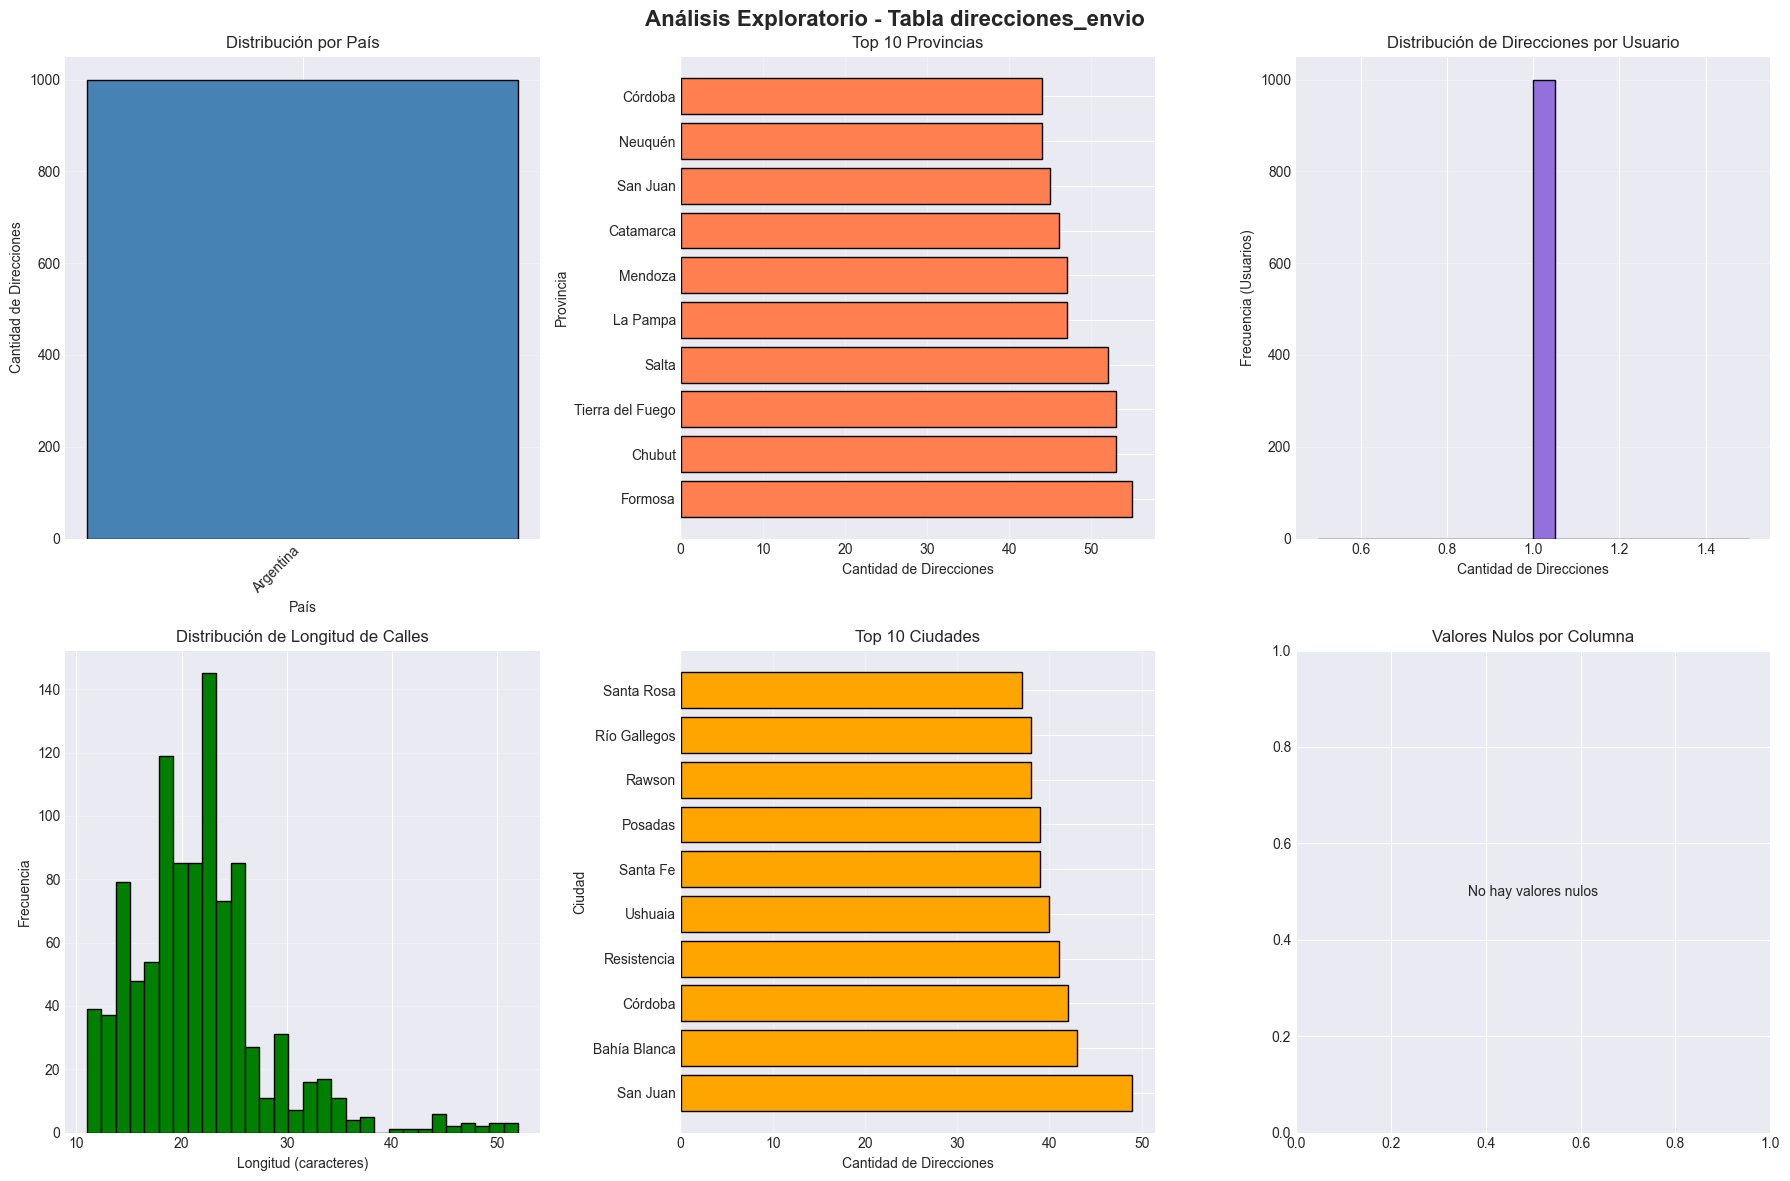

✓ Visualizaciones generadas correctamente


In [17]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla direcciones_envio', fontsize=16, fontweight='bold')

# 1. Distribución por país
ax1 = axes[0, 0]
distribucion_pais = df_direcciones['pais'].value_counts()
ax1.bar(range(len(distribucion_pais)), distribucion_pais.values, color='steelblue', edgecolor='black')
ax1.set_title('Distribución por País')
ax1.set_xlabel('País')
ax1.set_ylabel('Cantidad de Direcciones')
ax1.set_xticks(range(len(distribucion_pais)))
ax1.set_xticklabels(distribucion_pais.index, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# 2. Top 10 provincias
ax2 = axes[0, 1]
provincias_no_nulas = df_direcciones['provincia'].dropna()
if len(provincias_no_nulas) > 0:
    distribucion_provincia = provincias_no_nulas.value_counts().head(10)
    ax2.barh(range(len(distribucion_provincia)), distribucion_provincia.values, color='coral', edgecolor='black')
    ax2.set_title('Top 10 Provincias')
    ax2.set_xlabel('Cantidad de Direcciones')
    ax2.set_ylabel('Provincia')
    ax2.set_yticks(range(len(distribucion_provincia)))
    ax2.set_yticklabels(distribucion_provincia.index)
    ax2.grid(axis='x', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No hay datos de provincia', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Top 10 Provincias')

# 3. Distribución de direcciones por usuario
ax3 = axes[0, 2]
distribucion_usuario = df_direcciones['usuario_id'].value_counts()
ax3.hist(distribucion_usuario.values, bins=20, color='mediumpurple', edgecolor='black')
ax3.set_title('Distribución de Direcciones por Usuario')
ax3.set_xlabel('Cantidad de Direcciones')
ax3.set_ylabel('Frecuencia (Usuarios)')
ax3.grid(axis='y', alpha=0.3)

# 4. Longitud de direcciones (calle)
ax4 = axes[1, 0]
longitudes_calle = df_direcciones['calle'].astype(str).str.len()
ax4.hist(longitudes_calle, bins=30, color='green', edgecolor='black')
ax4.set_title('Distribución de Longitud de Calles')
ax4.set_xlabel('Longitud (caracteres)')
ax4.set_ylabel('Frecuencia')
ax4.grid(axis='y', alpha=0.3)

# 5. Top 10 ciudades
ax5 = axes[1, 1]
distribucion_ciudad = df_direcciones['ciudad'].value_counts().head(10)
ax5.barh(range(len(distribucion_ciudad)), distribucion_ciudad.values, color='orange', edgecolor='black')
ax5.set_title('Top 10 Ciudades')
ax5.set_xlabel('Cantidad de Direcciones')
ax5.set_ylabel('Ciudad')
ax5.set_yticks(range(len(distribucion_ciudad)))
ax5.set_yticklabels(distribucion_ciudad.index)
ax5.grid(axis='x', alpha=0.3)

# 6. Valores nulos por columna
ax6 = axes[1, 2]
nulos_por_columna = df_direcciones.isnull().sum()
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
if len(nulos_por_columna) > 0:
    ax6.barh(range(len(nulos_por_columna)), nulos_por_columna.values, color='red', edgecolor='black')
    ax6.set_title('Valores Nulos por Columna')
    ax6.set_xlabel('Cantidad de Nulos')
    ax6.set_ylabel('Columna')
    ax6.set_yticks(range(len(nulos_por_columna)))
    ax6.set_yticklabels(nulos_por_columna.index)
    ax6.grid(axis='x', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No hay valores nulos', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Valores Nulos por Columna')

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


### 7.1. Principales Insights y Problemas Encontrados


In [18]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: direcciones_envio")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_direcciones.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    direcciones_sin_usuario = df_direcciones[df_direcciones['usuario_id'].isnull()]
    if len(direcciones_sin_usuario) > 0:
        anomalias.append(('Sin usuario', len(direcciones_sin_usuario)))

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_direcciones))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_direcciones.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_direcciones['direccion_id'].nunique() == len(df_direcciones) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_direcciones)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Direcciones sin usuario
usuario_id_nulos = df_direcciones['usuario_id'].isnull().sum()
if usuario_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Direcciones sin usuario asignado: {usuario_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar usuario a direcciones sin usuario o eliminar si son inválidas'
    })

# Campos obligatorios nulos
campos_obligatorios = ['calle', 'ciudad', 'pais']
for campo in campos_obligatorios:
    nulos = df_direcciones[campo].isnull().sum()
    if nulos > 0:
        problemas.append({
            'Categoría': 'Valores Nulos Obligatorios',
            'Problema': f'{campo} nulos (campo obligatorio): {nulos}',
            'Severidad': 'Alta',
            'Acción Requerida': f'Completar valores nulos en {campo}'
        })

# Direcciones muy cortas
calles_cortas = df_direcciones[df_direcciones['calle'].astype(str).str.len() < 3]
if len(calles_cortas) > 0:
    problemas.append({
        'Categoría': 'Validación de Formato',
        'Problema': f'Direcciones muy cortas (< 3 caracteres): {len(calles_cortas)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar y corregir direcciones muy cortas'
    })

# Códigos postales inválidos
if 'codigo_postal' in df_direcciones.columns:
    codigos_postales = df_direcciones['codigo_postal'].dropna()
    if len(codigos_postales) > 0:
        patron_valido = r'^\d{4,8}$'
        codigos_invalidos = codigos_postales[~codigos_postales.astype(str).str.match(patron_valido, na=False)]
        if len(codigos_invalidos) > 0:
            problemas.append({
                'Categoría': 'Validación de Formato',
                'Problema': f'Códigos postales con formato inusual: {len(codigos_invalidos)}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y normalizar formatos de códigos postales'
            })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Sin usuario']:  # Ya incluido arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'direccion_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único de la dirección',
        'Uso': 'Relaciones y trazabilidad de direcciones'
    },
    {
        'Atributo': 'usuario_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica al usuario propietario de la dirección',
        'Uso': 'Asociación de direcciones con usuarios, gestión de envíos'
    },
    {
        'Atributo': 'calle',
        'Tipo': 'Dato de Dirección',
        'Relevancia Negocio': 'Alta - Dirección específica de envío',
        'Uso': 'Logística de envío, validación de direcciones'
    },
    {
        'Atributo': 'ciudad',
        'Tipo': 'Dato Geográfico',
        'Relevancia Negocio': 'Alta - Ciudad de destino',
        'Uso': 'Cálculo de costos de envío, análisis geográfico'
    },
    {
        'Atributo': 'provincia',
        'Tipo': 'Dato Geográfico',
        'Relevancia Negocio': 'Media - Provincia/estado de destino',
        'Uso': 'Análisis regional, cálculo de envíos'
    },
    {
        'Atributo': 'codigo_postal',
        'Tipo': 'Dato de Dirección',
        'Relevancia Negocio': 'Alta - Código postal para envío',
        'Uso': 'Validación de direcciones, cálculo de costos de envío'
    },
    {
        'Atributo': 'pais',
        'Tipo': 'Dato Geográfico',
        'Relevancia Negocio': 'Alta - País de destino',
        'Uso': 'Envíos internacionales, análisis geográfico'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'direcciones_envio' tiene:")
print("   - usuario_id → usuarios.usuario_id (relación N:1)")
print("   - Es una tabla de detalle que no es referenciada por otras tablas")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: direcciones_envio

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 1000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
   ✓ No se detectaron problemas significativos

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
     Atributo              Tipo                                       Relevancia Negocio                                                       Uso
 direccion_id    Clave Primaria               Alta - Identificador único de la dirección                  Relaciones y trazabilidad de direcciones
   usuario_id     Clave Foránea Alta - Identifica al usuario propietario de la dirección Asociación de direcciones con usuarios, gestión de envíos
        calle Dato de Dirección                     Alta - Dirección específica de envío             Logística de envío, validación de direcciones
       ciudad   Dato Geográfico                                 Alta - Ciuda

In [19]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos en campos opcionales
campos_opcionales = ['departamento', 'provincia', 'distrito', 'estado', 'codigo_postal']
nulos_opcionales = df_direcciones[campos_opcionales].isnull().sum().sum()
if nulos_opcionales > 0:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Campos Opcionales',
        'Decisión': 'Mantener valores nulos. Los campos opcionales pueden estar vacíos según el diseño.',
        'Justificación': f'Se encontraron {nulos_opcionales} valores nulos en campos opcionales, lo cual es válido.',
        'Prioridad': 'N/A'
    })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Campos Opcionales',
        'Decisión': 'No se requieren acciones. Todos los campos opcionales están completos.',
        'Justificación': 'Todos los campos opcionales tienen valores.',
        'Prioridad': 'N/A'
    })

# 2. Valores nulos en campos obligatorios
campos_obligatorios = ['calle', 'ciudad', 'pais']
nulos_obligatorios = 0
for campo in campos_obligatorios:
    nulos = df_direcciones[campo].isnull().sum()
    if nulos > 0:
        nulos_obligatorios += nulos
        decisiones.append({
            'Aspecto': f'{campo} Nulos (Obligatorio)',
            'Decisión': f'Completar valores nulos en {campo}.',
            'Justificación': f'Se encontraron {nulos} valores nulos en {campo}, que es un campo obligatorio.',
            'Prioridad': 'Alta'
        })

if nulos_obligatorios == 0:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Campos Obligatorios',
        'Decisión': 'No se requieren acciones. Todos los campos obligatorios están completos.',
        'Justificación': 'Todos los campos obligatorios tienen valores.',
        'Prioridad': 'N/A'
    })

# 3. Duplicados
decisiones.append({
    'Aspecto': 'Duplicados',
    'Decisión': 'No se requieren acciones. No se encontraron duplicados completos.',
    'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
    'Prioridad': 'N/A'
})

# 4. Direcciones sin usuario
usuario_id_nulos = df_direcciones['usuario_id'].isnull().sum()
if usuario_id_nulos > 0:
    decisiones.append({
        'Aspecto': 'Direcciones sin Usuario',
        'Decisión': 'Asignar usuario a direcciones sin usuario o eliminar si son inválidas.',
        'Justificación': f'Se encontraron {usuario_id_nulos} direcciones sin usuario asignado.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Direcciones sin Usuario',
        'Decisión': 'No se requieren acciones. Todas las direcciones tienen usuario.',
        'Justificación': 'Todas las direcciones tienen un usuario asignado.',
        'Prioridad': 'N/A'
    })

# 5. Validación de formatos
calles_cortas = df_direcciones[df_direcciones['calle'].astype(str).str.len() < 3]
if len(calles_cortas) > 0:
    decisiones.append({
        'Aspecto': 'Direcciones Muy Cortas',
        'Decisión': 'Revisar y corregir direcciones muy cortas.',
        'Justificación': f'Se encontraron {len(calles_cortas)} direcciones muy cortas.',
        'Prioridad': 'Media'
    })

if 'codigo_postal' in df_direcciones.columns:
    codigos_postales = df_direcciones['codigo_postal'].dropna()
    if len(codigos_postales) > 0:
        patron_valido = r'^\d{4,8}$'
        codigos_invalidos = codigos_postales[~codigos_postales.astype(str).str.match(patron_valido, na=False)]
        if len(codigos_invalidos) > 0:
            decisiones.append({
                'Aspecto': 'Códigos Postales Inválidos',
                'Decisión': 'Revisar y normalizar formatos de códigos postales.',
                'Justificación': f'Se encontraron {len(codigos_invalidos)} códigos postales con formato inusual.',
                'Prioridad': 'Media'
            })

# 6. Normalización de texto
decisiones.append({
    'Aspecto': 'Normalización de Texto',
    'Decisión': 'Aplicar trim() a todos los campos de texto para eliminar espacios al inicio/final.',
    'Justificación': 'Aunque no se detectaron problemas significativos, es una buena práctica preventiva.',
    'Prioridad': 'Baja'
})

# 7. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                             Aspecto                                                                           Decisión                                                                         Justificación Prioridad
  Valores Nulos en Campos Opcionales             No se requieren acciones. Todos los campos opcionales están completos.                                           Todos los campos opcionales tienen valores.       N/A
Valores Nulos en Campos Obligatorios           No se requieren acciones. Todos los campos obligatorios están completos.                                         Todos los campos obligatorios tienen valores.       N/A
                          Duplicados                  No se requieren acciones. No se encontraron duplicados completos.                  Las restricciones de clave primaria están funcionando correctamente.       N/A
             Direcciones sin Usuario                    No se requieren acciones. Todas las dire

In [20]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: direcciones_envio")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'direcciones_envio' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'direcciones_envio' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'direcciones_envio' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'direcciones_envio'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'direcciones_envio',
        'Columna Origen': 'usuario_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'usuarios',
        'Columna Destino': 'usuario_id',
        'Descripción': 'Una dirección pertenece a un usuario'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_direcciones)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: direccion_id")
print(f"Clave foránea: usuario_id")
print(f"Relaciones entrantes: {len([r for r in relaciones if r['Tipo Relación'] == 'N:1'])}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_direcciones.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: direcciones_envio

ESTRUCTURA DE COLUMNAS:
  column_name         data_type  character_maximum_length  numeric_precision  numeric_scale is_nullable                                          column_default constraints
 direccion_id           integer                       NaN               32.0            0.0          NO nextval('direcciones_envio_direccion_id_seq'::regclass) PRIMARY KEY
   usuario_id           integer                       NaN               32.0            0.0         YES                                                    None FOREIGN KEY
        calle character varying                     255.0                NaN            NaN          NO                                                    None            
       ciudad character varying                     100.0                NaN            NaN          NO                                                    None            
 departamento character varying                     100.0                NaN        

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `direcciones_envio` revela una estructura de datos bien definida que almacena las direcciones de envío asociadas a los usuarios. La tabla cumple con su propósito de gestionar información geográfica y de direcciones, con relaciones claras hacia usuarios. La calidad de los datos es buena, con integridad de clave primaria correcta. Se identificaron campos opcionales que pueden estar nulos según el diseño, y se realizaron validaciones de formatos para códigos postales y direcciones.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Estructura Clara**: La tabla tiene una estructura bien definida con campos geográficos y de dirección
3. **Relaciones Bien Definidas**: Las relaciones con usuarios están correctamente establecidas
4. **Campos Geográficos**: Permite análisis geográfico y gestión de envíos por ubicación
5. **Flexibilidad**: Campos opcionales permiten adaptarse a diferentes formatos de direcciones

### Áreas de Mejora

1. **Validación de Formatos**: Implementar validaciones más estrictas para códigos postales según el país
2. **Normalización de Texto**: Aplicar trim() y normalización de caracteres especiales
3. **Consistencia Geográfica**: Validar consistencia entre ciudad, provincia y país usando bases de datos de referencia

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis de Texto**: Se analizaron en detalle los campos de texto (calle, ciudad, provincia, etc.)
3. ✅ **Validación de Formatos**: Se validaron formatos de códigos postales y direcciones
4. ✅ **Análisis Geográfico**: Se analizó la distribución geográfica y consistencia de datos
5. ✅ **Identificación de Relaciones**: Se identificaron y verificaron las relaciones con usuarios
6. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones
